### Phonopy and CHGNet workflow custom 

1. relax a primitive cell 
2. run phonons on the primitive cell with CHGNet 
3. generate a supercell with a defect using DOPED
4. run symmetry-free phonons with that supercell using CHGNet

In [1]:
from pymatgen.io.phonopy import get_displaced_structures, get_phonopy_structure, get_pmg_structure
from pymatgen.core import Structure 
import numpy as np 
import warnings
import tqdm 
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
struct = Structure.from_file('agi.vasp').get_primitive_structure()

In [ ]:
matrix = [3,3,2]

Structure Summary
Lattice
    abc : 4.559409285726944 4.559409285726942 7.4431080261777804
 angles : 90.0 90.0 119.99999999999882
 volume : 133.9991713402973
      A : -2.2797046428635124 -3.948564267690172 -1e-16
      B : -2.2797046428635124 3.9485642676901707 1e-16
      C : 0.0 1e-16 -7.4431080261777804
    pbc : True True True
PeriodicSite: Ag (-2.28, -1.316, -3.705) [0.6667, 0.3333, 0.4978]
PeriodicSite: Ag (-2.28, 1.316, -7.426) [0.3333, 0.6667, 0.9978]
PeriodicSite: I (-2.28, -1.316, -0.9106) [0.6667, 0.3333, 0.1223]
PeriodicSite: I (-2.28, 1.316, -4.632) [0.3333, 0.6667, 0.6223]

In [7]:
from chgnet.model.dynamics import StructOptimizer
from phonopy import Phonopy 

def get_phonons_workflow(structure,matrix,**displacement_kws):
    # 1. relax the primitive
    so = StructOptimizer(use_device='mps')
    relaxed = so.relax(struct,fmax=1e-4,verbose=False)
    final_structure = relaxed['final_structure']
    # 2. get the displaced structures 
    displacements = get_displaced_structures(final_structure,supercell_matrix=matrix)[1:] # first item is the original structure
    forces = []
    for d in displacements:
        oneshot = so.relax(d,steps=1,relax_cell=False,verbose=False)
        forces.append(oneshot['trajectory'].forces[-1])

    phonon = Phonopy(
        get_phonopy_structure(final_structure),
        supercell_matrix = matrix,
       # primitive_matrix = [[1,0,0],[0,1,0],[0,0,1]], #unsure about this
        #symprec=0.01,
        #is_symmetry=True,
    )    

    set_of_forces = [np.array(f) for f in forces]
    phonon.generate_displacements()
    phonon.produce_force_constants(forces=set_of_forces)
    return(phonon,final_structure)


In [ ]:
prim_phonon,prim_struct = get_phonons_workflow(
    structure=struct,
    matrix=matrix
)

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps


<module 'matplotlib.pyplot' from '/Users/badw/miniconda3/envs/py311/lib/python3.11/site-packages/matplotlib/pyplot.py'>

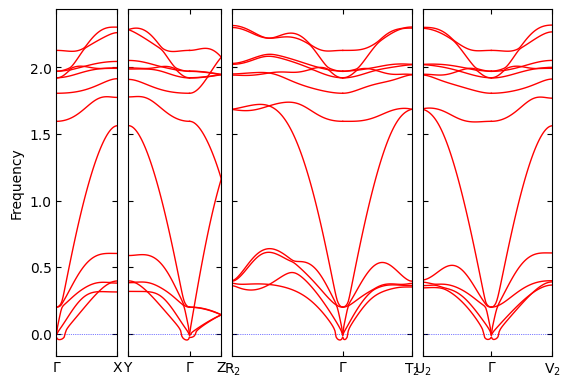

In [9]:
prim_phonon.auto_band_structure()
prim_phonon.plot_band_structure()

In [ ]:
def get_relaxed_vacancy_structure(structure,vacant_atom,matrix):
    supercell = structure * matrix
    for i,atom in enumerate(supercell):
        if atom.species_string == vacant_atom:
            index = i
            break
    print(len(supercell),end=' ')
    supercell.remove_sites([index])
    print(len(supercell))
    so = StructOptimizer(use_device='mps')
    relaxed = so.relax(supercell,fmax=1e-4,steps=1000,verbose=True,relax_cell=False)
    final_structure = relaxed['final_structure']
    return(final_structure)
    

supercell_relaxed = get_relaxed_vacancy_structure(prim_struct,'Ag',matrix=matrix)

72 71
CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps
      Step     Time          Energy          fmax
FIRE:    0 11:51:56     -183.678787        0.180167
FIRE:    1 11:51:56     -183.683696        0.172821
FIRE:    2 11:51:57     -183.692888        0.158335
FIRE:    3 11:51:57     -183.704839        0.139465
FIRE:    4 11:51:57     -183.718110        0.118560
FIRE:    5 11:51:57     -183.731161        0.096249
FIRE:    6 11:51:57     -183.742570        0.070679
FIRE:    7 11:51:57     -183.750933        0.044207
FIRE:    8 11:51:57     -183.754538        0.012619
FIRE:    9 11:51:57     -183.754538        0.012545
FIRE:   10 11:51:57     -183.754572        0.012435
FIRE:   11 11:51:57     -183.754589        0.012208
FIRE:   12 11:51:57     -183.754640        0.011943
FIRE:   13 11:51:58     -183.754691        0.011595
FIRE:   14 11:51:58     -183.754758        0.011221
FIRE:   15 11:51:58     -183.754826        0.010790
FIRE:   16 11:51:58     -183.754911    

In [26]:
def get_defect_phonons_workflow(structure,**displacement_kws): # this should be combined with the previous function 
    # 2. get the displaced structures 
    phonon = Phonopy(
        get_phonopy_structure(structure),
        supercell_matrix = np.array([[1,0,0],[0,1,0],[0,0,1]]),
        #primitive_matrix = np.array([[1,0,0],[0,1,0],[0,0,1]]), #unsure about this
        symprec=1e-10,
        is_symmetry=False,
    )    
    phonon.generate_displacements()
    print(len(phonon.get_displacements()))
    displacements = [get_pmg_structure(phonopy_struct) for phonopy_struct in phonon.get_supercells_with_displacements()]

    forces = []

    so = StructOptimizer(use_device='mps')
    for d in tqdm.tqdm(displacements):
        oneshot = so.relax(d,steps=1,relax_cell=False,verbose=False)
        forces.append(oneshot['trajectory'].forces[-1])

    set_of_forces = [np.array(f) for f in forces]
    phonon.produce_force_constants(forces=set_of_forces)
    return(phonon)

In [27]:
defphonon = get_defect_phonons_workflow(supercell_relaxed)

426
CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps


100%|██████████| 426/426 [00:38<00:00, 11.18it/s]


<module 'matplotlib.pyplot' from '/Users/badw/miniconda3/envs/py311/lib/python3.11/site-packages/matplotlib/pyplot.py'>

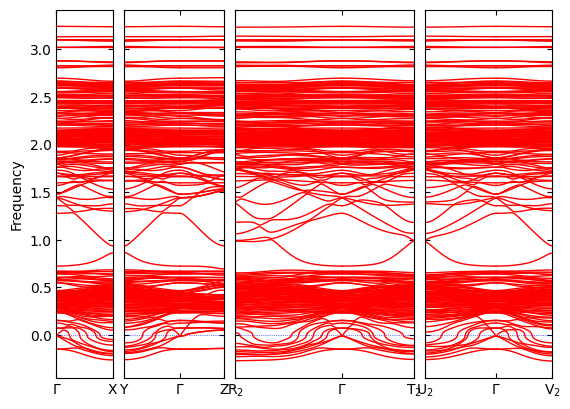

In [28]:
defphonon.auto_band_structure()
defphonon.plot_band_structure()

to use with `puppy` as a quick hack for now we need to save SPOSCARs and FORCE_SETS

In [29]:
import os 
from phonopy.file_IO import write_FORCE_SETS

! find . -name "SPOSCAR*" -delete ; find . -name "FORCE_SETS*" -delete 
host_dir = './agi/v_Ag/host/'
defect_dir = './agi/v_Ag/defect/'
os.makedirs(host_dir,exist_ok=True)
os.makedirs(defect_dir,exist_ok=True)

get_pmg_structure(prim_phonon.supercell).to(host_dir+'SPOSCAR',fmt='poscar')
write_FORCE_SETS(prim_phonon.dataset,host_dir+'FORCE_SETS')

get_pmg_structure(defphonon.supercell).to(defect_dir+'SPOSCAR',fmt='poscar')
write_FORCE_SETS(defphonon.dataset,defect_dir+'FORCE_SETS')
! gzip -rf agi/*


In [30]:
import warnings 
import pprint
from puppy.unfolder import PhononUnfoldingandProjection as Puppy
import numpy as np 
warnings.simplefilter('ignore')


directories = {'defect_directory':host_dir,
               'host_directory':defect_dir}


puppy = Puppy(
    defect_directory=defect_dir,
    host_directory=host_dir,
    line_density=50,
    nearest_neighbour_tolerance=3
)
pp = pprint.PrettyPrinter(depth=4)
pp.pprint(puppy.get_neighbour_sites()) # shows what you are interested in around the defect

puppy.get_host_phonons(eigenvectors=True)
puppy.get_defect_phonons()
print(puppy.matrix)
puppy.matrix = np.array([[3,0,0],[0,3,0],[0,0,2]])
puppy.matrix

found v_Ag vacancy defect at site [0.222,0.111,0.247] in structure (index = 0)
{'Ag': [], 'I': [59, 53, 35, 57]}
[[3. 0. 0.]
 [3. 3. 0.]
 [0. 0. 2.]]


array([[3, 0, 0],
       [0, 3, 0],
       [0, 0, 2]])

In [31]:
puppy.unfold()
puppy.eigenvectors_to_eigendisplacements()

generating_eigendisplacements...: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


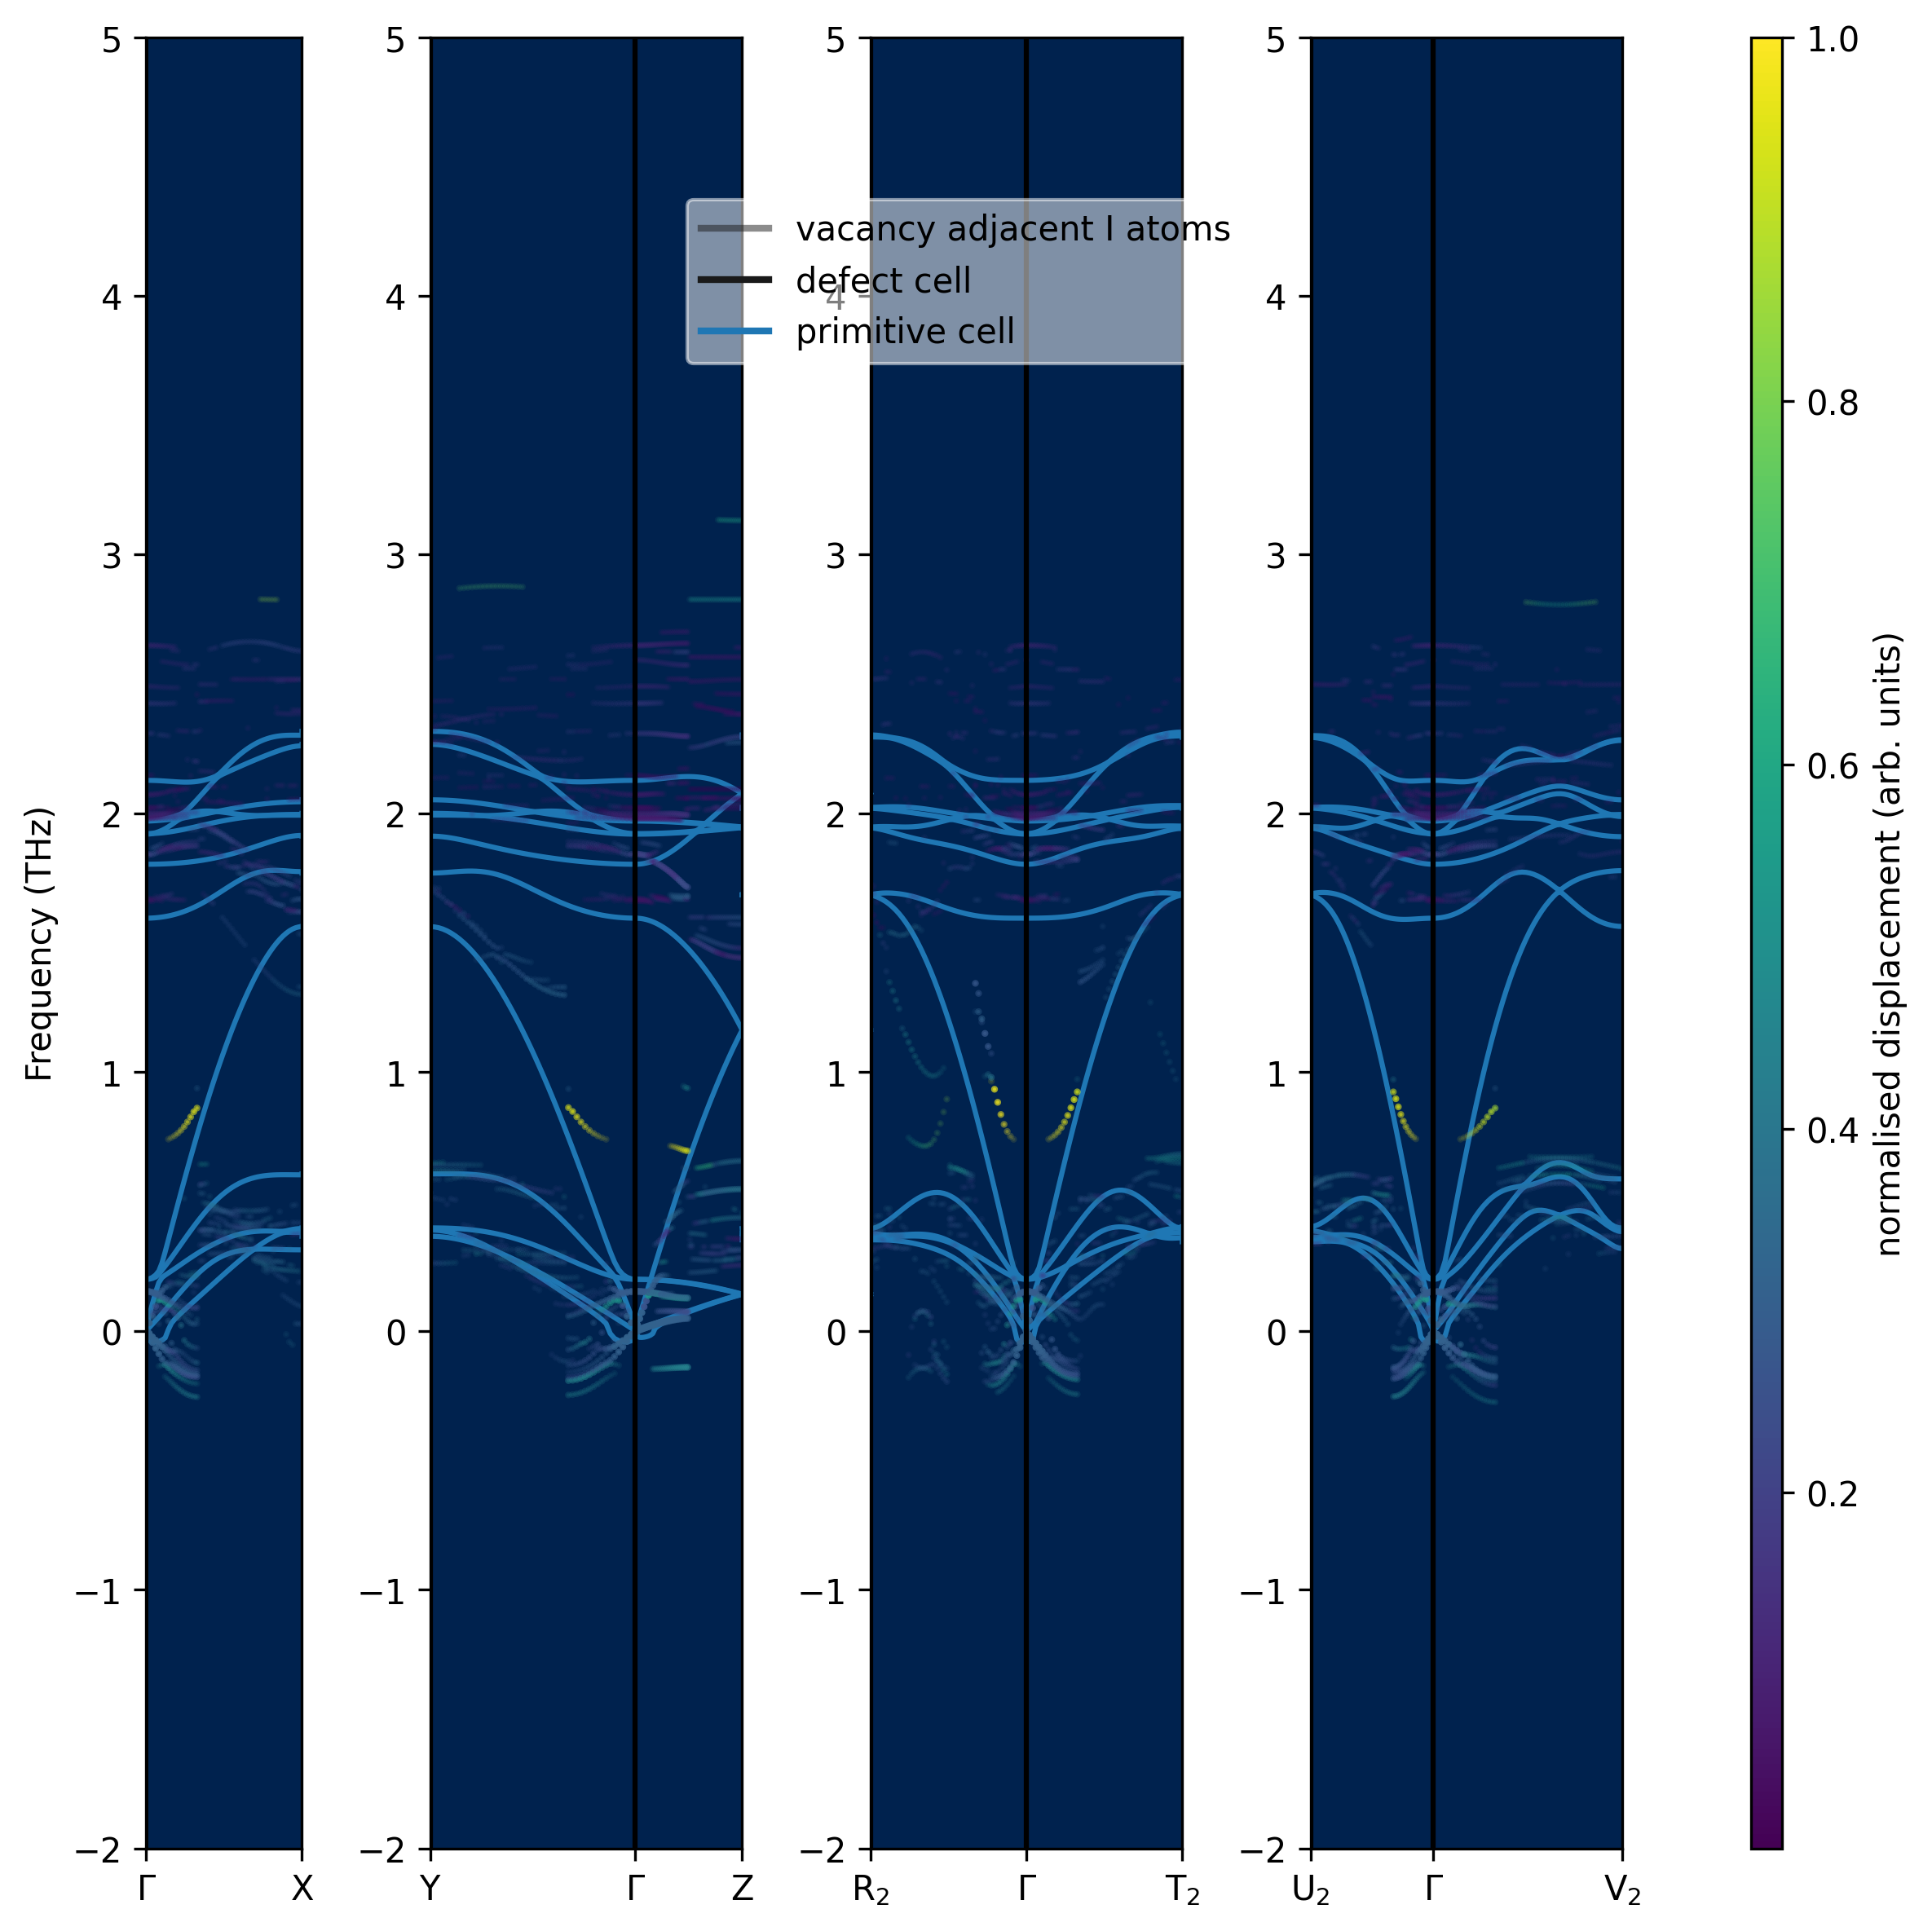

In [33]:
import matplotlib as mpl 
cmap = 'cividis'
mpl.rcParams['pdf.fonttype'] = 42
comap = mpl.colormaps.get_cmap(cmap)
mpl.rcParams["axes.facecolor"] = comap.colors[0]

plot_kws={'s':1,'rasterized':True,'edgecolor':None,'linewidths':None}

legend_kws={'facecolor':'white',
                        'framealpha':0.5,
                        'edgecolor':'white',
                        'bbox_to_anchor':[0.5,0.9],
                        'loc':'upper center'}

fig,axes = puppy.plot_unfold(
    with_prim=True,
    threshold=0.1,
    atom='I',
    plot_kws=plot_kws,
    legend_kws=legend_kws
)
#[ax.set_ylim(-10,30) for ax in axes[:-1]]